In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from expanders import *

# Random regular graphs vs LPS3

In [2]:
p = sympy.prime(13)

builder_lps3 = LPS3(p, remove_parallel_edges=False, remove_self_edges=False)
builder_lps3.build()
G_lps3 = builder_lps3.G

n = G_lps3.number_of_nodes()

# Degree
d = 3
builder_rrg = RRG(d, n-1)
builder_rrg.build()
G_rrg = builder_rrg.G

### Graphs

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


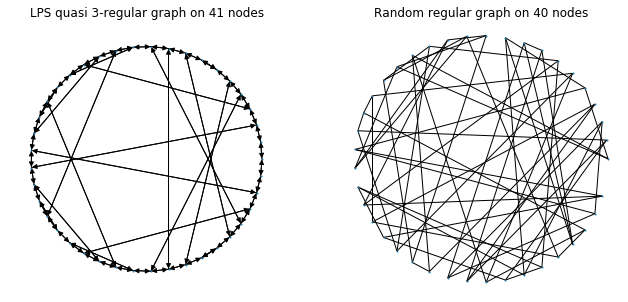

In [3]:
# save layout
pos = nx.shell_layout(G_lps3)

fig, axes = plt.subplots(figsize=(11, 5), nrows=1, ncols=2)

ax = axes[0]
nx.draw_networkx(G_lps3, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('LPS quasi 3-regular graph on {} nodes'.format(G_lps3.number_of_nodes()))
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_rrg, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Random regular graph on {} nodes'.format(G_rrg.number_of_nodes()))
ax.axis('off')

plt.show()

### Eigenvalues vs Alon-Boppana bound

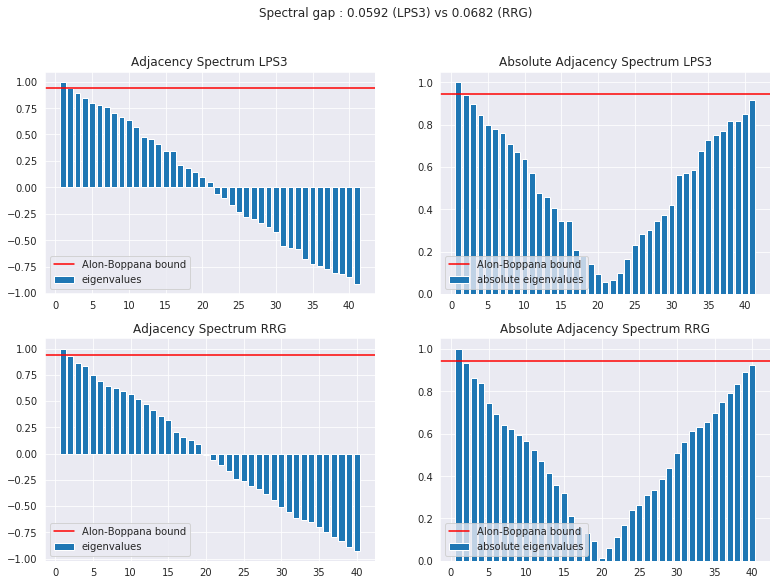

In [4]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 9), nrows=2, ncols=2)

    fig.suptitle('Spectral gap : {:.4f} (LPS3) vs {:.4f} (RRG)'.format(
        builder_lps3.normalized_spectral_gap,
        builder_rrg.normalized_spectral_gap
    ))
    
    ax = axes[0, 0]    
    ax.bar(range(1, n+1), builder_lps3.normalized_spectrum, label='eigenvalues')
    ax.axhline(y=alon_boppana(d, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum LPS3')
    ax.legend(loc='lower left')

    ax = axes[0, 1]
    ax.bar(range(1, n+1), np.abs(builder_lps3.normalized_spectrum), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(d, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum LPS3')
    ax.legend(loc='lower left')

    ax = axes[1, 0]    
    ax.bar(range(1, n), builder_rrg.normalized_spectrum, label='eigenvalues')
    ax.axhline(y=alon_boppana(d, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum RRG')
    ax.legend(loc='lower left')

    ax = axes[1, 1]
    ax.bar(range(1, n), np.abs(builder_rrg.normalized_spectrum), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(d, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum RRG')
    ax.legend(loc='lower left')

plt.show()

In [5]:
[builder_lps3.is_ramanujan, builder_rrg.is_ramanujan] 

[True, True]

### Mixing times

100%|██████████| 10/10 [00:00<00:00, 261.18it/s]


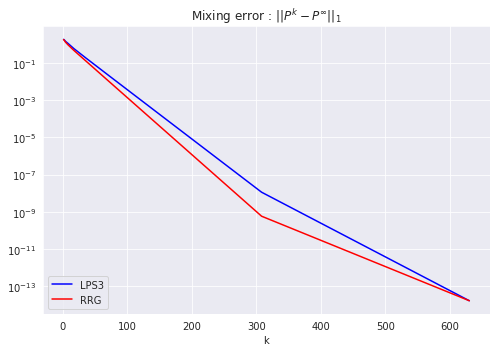

In [6]:
MIXING_METRIC = 1

P_inf_lps3 = np.array([builder_lps3.invariant_distribution,]*n)
P_inf_rrg = np.array([builder_rrg.invariant_distribution,]*(n-1))

# Log scale of exponents to test
exponents = np.unique(np.logspace(0, 2.8, 10, dtype=int))
n_iter = len(exponents)

mixing_err_lps3 = np.zeros(n_iter)
mixing_err_rrg = np.zeros(n_iter)

with tqdm(total=n_iter) as pbar:
    for k, exponent in enumerate(exponents):
        Pk_lps3 = builder_lps3.transition_matrix ** exponent
        mixing_err_lps3[k] = np.linalg.norm(Pk_lps3-P_inf_lps3, MIXING_METRIC)

        Pk_rrg = builder_rrg.transition_matrix ** exponent
        mixing_err_rrg[k] = np.linalg.norm(Pk_rrg-P_inf_rrg, MIXING_METRIC)

        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.semilogy(exponents, mixing_err_lps3, label='LPS3', color='b')
    ax.semilogy(exponents, mixing_err_rrg, label='RRG', color='r')
    ax.set_xlabel('k')
    ax.set_title('Mixing error : $||P^k - P^{\infty}||_{1}$')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Expected entropic evolution

Compute $t\mapsto \mathbb{E}\big[H(vP^t) - H(v)\big]$ i.e the increase in entropy after $t$ steps of mixing average across random initial distribution $v$ sampled uniformly.

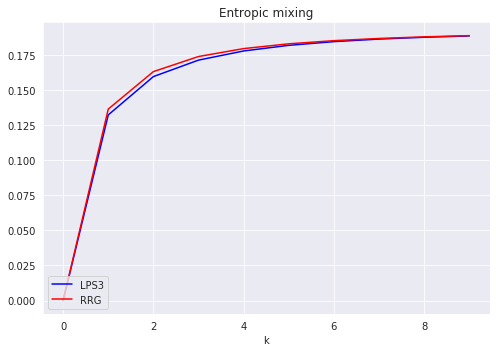

In [7]:
walk_length = 10
n_samples = int(1e3)
entropy_diff_lps3 = builder_lps3.entropy_mixing(n_samples, walk_length)
entropy_diff_rrg = builder_rrg.entropy_mixing(n_samples, walk_length)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(entropy_diff_lps3, label='LPS3', color='b')
    ax.plot(entropy_diff_rrg, label='RRG', color='r')
    ax.set_xlabel('k')
    ax.set_title('Entropic mixing')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Mutual Information Mixing

We define the Mutual Information Mixing on graph $\mathcal{G}$ as :
$$
mi_t = MI(X_0, X_t) = KL(p_{(X_0, X_t)} || p_{X_0} \otimes p_{X_t} )
$$
where $X_0 \sim \text{Uniform}(\mathcal{G})$ and $X_t = \text{random state of the walk on } \mathcal{G} \text{ after } t \text{ steps}$.

Intuitively, if a graph has good mixing properties, the distribution of $X_t$ shares very little information with the initial seeding $X_0$.

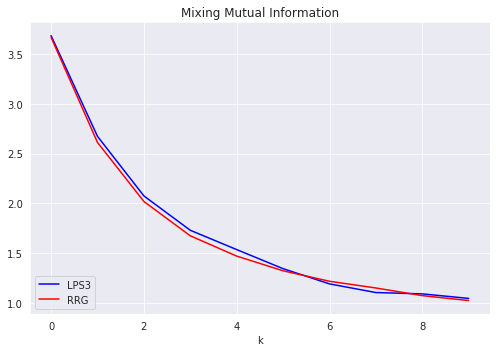

In [8]:
walk_length = 10
n_samples = int(1e3)
mixing_mi_lps3 = builder_lps3.mi_mixing(n_samples, walk_length)
mixing_mi_rrg = builder_rrg.mi_mixing(n_samples, walk_length)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(mixing_mi_lps3, label='LPS3', color='b')
    ax.plot(mixing_mi_rrg, label='RRG', color='r')
    ax.set_xlabel('k')
    ax.set_title('Mixing Mutual Information')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# Random regular graphs vs Paley

In [9]:
# Pick a prime number and an exponent
p = sympy.prime(3)

exponent = 2

if p % 4 == 3:
    assert exponent % 2 == 0, 'Choose an even exponent'
elif p%4 != 1:
    raise Exception('Try again.')

q = p ** exponent

# The only condition is that q = 1 mod 4
assert q % 4 == 1, '{} != 1 mod 4'.format(q)

print('q = {}'.format(q))

builder_paley = Paley(q)
builder_paley.build()
G_paley = builder_paley.G

n = G_paley.number_of_nodes()

# Degree
d = (q-1)//2
builder_rrg = RRG(d, n)
builder_rrg.build()
G_rrg = builder_rrg.G

q = 25


### Graphs

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


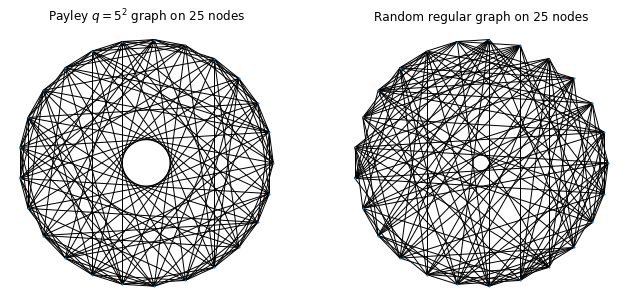

In [10]:
# save layout
pos = nx.shell_layout(G_paley)

fig, axes = plt.subplots(figsize=(11, 5), nrows=1, ncols=2)

ax = axes[0]
nx.draw_networkx(G_paley, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Payley $q={}^{}$ graph on {} nodes'.format(p, exponent, G_paley.number_of_nodes()))
ax.axis('off')

ax = axes[1]
nx.draw_networkx(G_rrg, pos=pos, ax=ax, with_labels=False, node_size=1)
ax.set_title('Random regular graph on {} nodes'.format(G_rrg.number_of_nodes()))
ax.axis('off')

plt.show()

### Eigenvalues vs Alon-Boppana bound

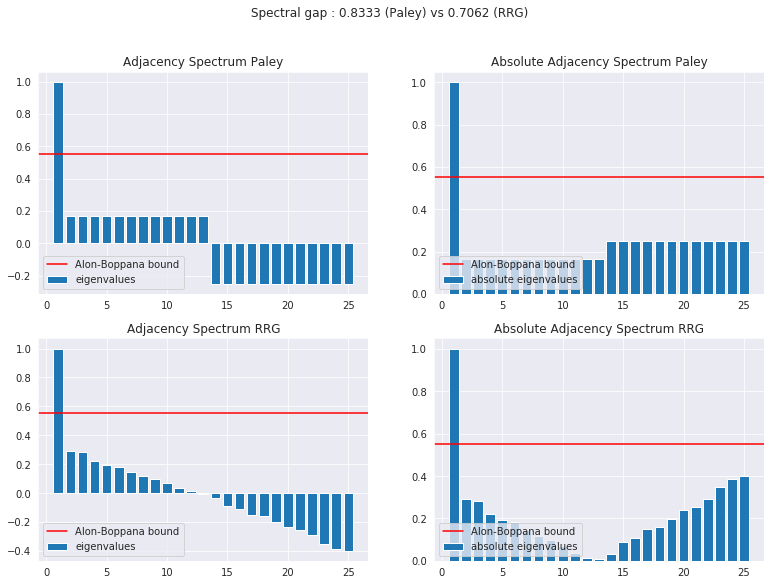

In [11]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(figsize=(13, 9), nrows=2, ncols=2)

    fig.suptitle('Spectral gap : {:.4f} (Paley) vs {:.4f} (RRG)'.format(
        builder_paley.normalized_spectral_gap,
        builder_rrg.normalized_spectral_gap
    ))
    
    ax = axes[0, 0]    
    ax.bar(range(1, n+1), builder_paley.normalized_spectrum, label='eigenvalues')
    ax.axhline(y=alon_boppana(d, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum Paley')
    ax.legend(loc='lower left')

    ax = axes[0, 1]
    ax.bar(range(1, n+1), np.abs(builder_paley.normalized_spectrum), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(d, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum Paley')
    ax.legend(loc='lower left')

    ax = axes[1, 0]    
    ax.bar(range(1, n+1), builder_rrg.normalized_spectrum, label='eigenvalues')
    ax.axhline(y=alon_boppana(d, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Adjacency Spectrum RRG')
    ax.legend(loc='lower left')

    ax = axes[1, 1]
    ax.bar(range(1, n+1), np.abs(builder_rrg.normalized_spectrum), label='absolute eigenvalues')
    ax.axhline(y=alon_boppana(d, normalized=True), color='r', label='Alon-Boppana bound')
    ax.set_title('Absolute Adjacency Spectrum RRG')
    ax.legend(loc='lower left')

plt.show()

In [12]:
[builder_paley.is_ramanujan, builder_rrg.is_ramanujan] 

[True, True]

### Mixing times

100%|██████████| 10/10 [00:00<00:00, 304.96it/s]


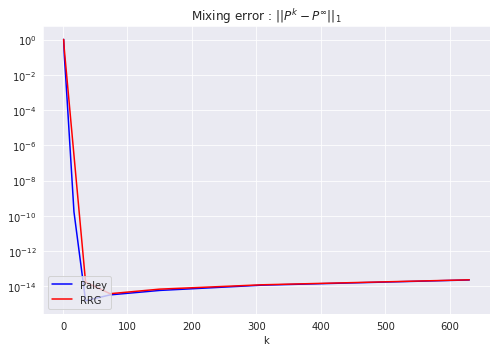

In [13]:
MIXING_METRIC = 1

P_inf_paley = np.array([builder_paley.invariant_distribution,]*n)
P_inf_rrg = np.array([builder_rrg.invariant_distribution,]*n)

# Log scale of exponents to test
exponents = np.unique(np.logspace(0, 2.8, 10, dtype=int))
n_iter = len(exponents)

mixing_err_paley = np.zeros(n_iter)
mixing_err_rrg = np.zeros(n_iter)

with tqdm(total=n_iter) as pbar:
    for k, exponent in enumerate(exponents):
        Pk_paley = builder_paley.transition_matrix ** exponent
        mixing_err_paley[k] = np.linalg.norm(Pk_paley-P_inf_paley, MIXING_METRIC)

        Pk_rrg = builder_rrg.transition_matrix ** exponent
        mixing_err_rrg[k] = np.linalg.norm(Pk_rrg-P_inf_rrg, MIXING_METRIC)

        pbar.update(1)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.semilogy(exponents, mixing_err_paley, label='Paley', color='b')
    ax.semilogy(exponents, mixing_err_rrg, label='RRG', color='r')
    ax.set_xlabel('k')
    ax.set_title('Mixing error : $||P^k - P^{\infty}||_{1}$')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Expected entropic evolution

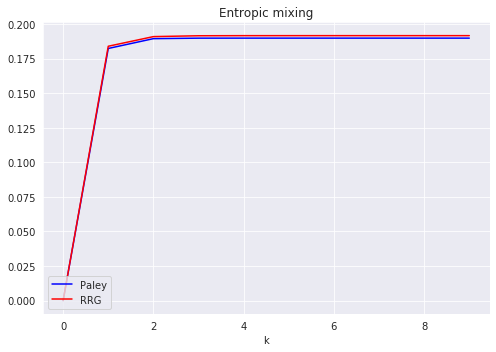

In [14]:
walk_length = 10
n_samples = int(1e3)
entropy_diff_paley = builder_paley.entropy_mixing(n_samples, walk_length)
entropy_diff_rrg = builder_rrg.entropy_mixing(n_samples, walk_length)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(entropy_diff_paley, label='Paley', color='b')
    ax.plot(entropy_diff_rrg, label='RRG', color='r')
    ax.set_xlabel('k')
    ax.set_title('Entropic mixing')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Mutual Information Mixing

We define the Mutual Information Mixing on graph $\mathcal{G}$ as :
$$
mi_t = MI(X_0, X_t) = KL(p_{(X_0, X_t)} || p_{X_0} \otimes p_{X_t} )
$$
where $X_0 \sim \text{Uniform}(\mathcal{G})$ and $X_t = \text{random state of the walk on } \mathcal{G} \text{ after } t \text{ steps}$.

Intuitively, if a graph has good mixing properties, the distribution of $X_t$ shares very little information with the initial seeding $X_0$.

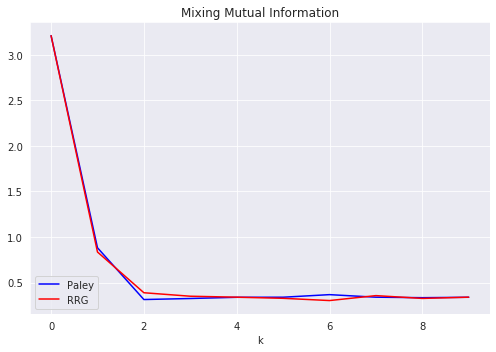

In [15]:
walk_length = 10
n_samples = int(1e3)
mixing_mi_paley = builder_paley.mi_mixing(n_samples, walk_length)
mixing_mi_rrg = builder_rrg.mi_mixing(n_samples, walk_length)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    ax.plot(mixing_mi_paley, label='Paley', color='b')
    ax.plot(mixing_mi_rrg, label='RRG', color='r')
    ax.set_xlabel('k')
    ax.set_title('Mixing Mutual Information')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

### Conclusion

At same number of vertices and degree, regular random graphs are better expanders than the LPS3 construct (which makes sense: to obtain exactly regular LPS3 graphs we had to artificially add self and parallel edges to account for the redundant links in $\mathbb{Z}/p\mathbb{Z}$, so we are "wasting" some of our degree budget).

Paley graphs have slightly better expansion properties than RRG, due to the fact that Paley graphs are exactly Ramanujan (by opposition to RRG being only almost Ramanujan when large enough). 